In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
import math
import pandas as pd

import xgboost
import lightgbm
import catboost

from matplotlib.colors import ListedColormap
from scipy.stats import pearsonr
from itertools import combinations
from sklearn.base import BaseEstimator
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import (RandomForestClassifier,
                              ExtraTreesClassifier,
                              VotingClassifier)
from sklearn.tree import (DecisionTreeRegressor,
                          DecisionTreeClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

from scipy.special import comb
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer

In [2]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

### Задание 1. Bias-variance trade-off

**2 балла**

Продемонстрируйте bias-variance trade-off для `DecisionTreeRegressor` при изменении глубины дерева. Постройте регрессионную модель функции от одной независимой переменной, представленной в ячейке ниже, используя функцию `plot_regression_predictions` (можете ее как-то поменять, если захочется). Попробуйте разные значения глубины деревьев, при каком значении, на ваш взгляд, модель оптимальна, при каком variance становится слишком большим?

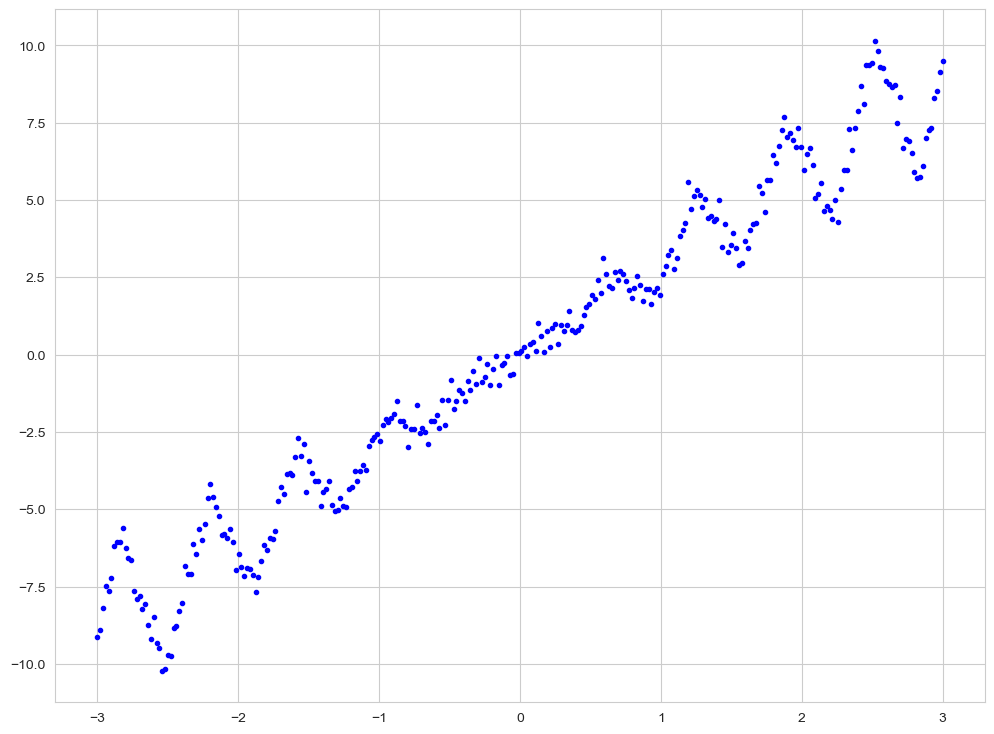

In [3]:
# Сгенерируем какую-нибудь необычную зависимость и научимся ее предсказывать
np.random.seed(42)
m = 300
X = np.linspace(-3, 3, m).reshape(-1, 1)
y = (3 + 2/np.pi * np.arcsin(np.cos(10 * X))) * X
y = y + np.random.randn(m, 1) / 3
plt.plot(X.reshape(-1), y.reshape(-1), "b.");

In [4]:
# Функция для отрисовки предсказаний деревьев решений в случае регрессии
def plot_regression_predictions(tree_reg, X, y, depth, axes=[-3, 3, -10, 10], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)
    plt.plot(x1, y_pred, linewidth=2, label=depth)

Изобразите, как меняются предсказания дерева при увеличении максимальной глубины (можно взять что-то в диапазоне от 1 до 15):

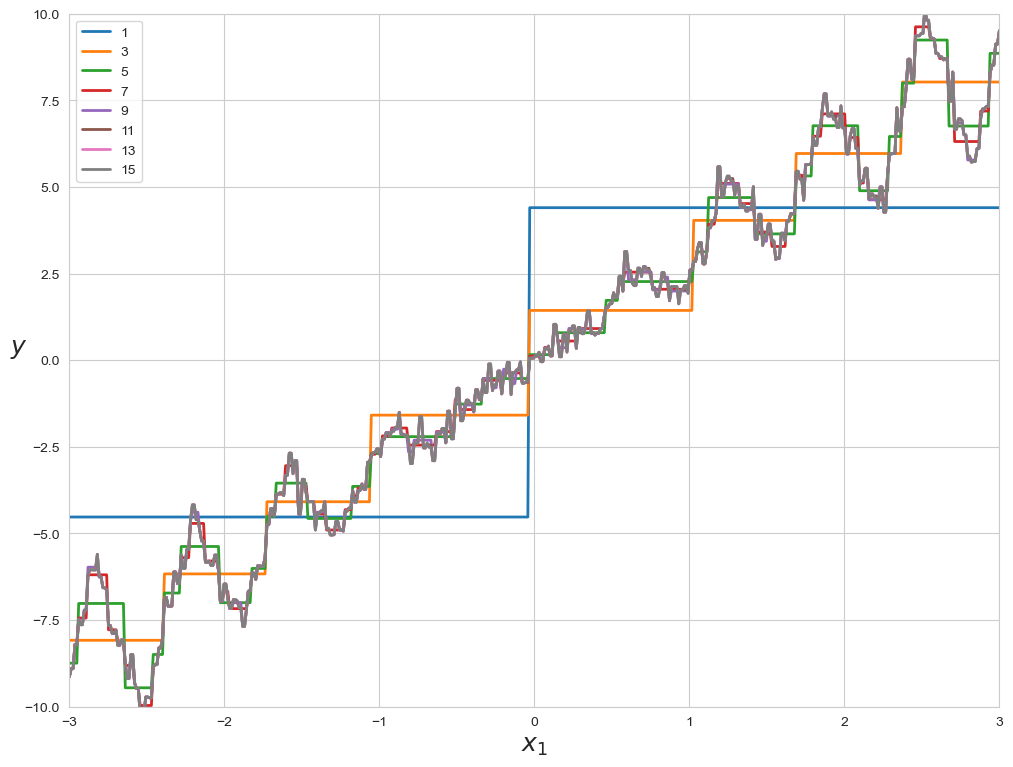

In [5]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
for depth in range(1, 16, 2):
    tree_reg = DecisionTreeRegressor(max_depth = depth)
    tree_reg.fit(X,y)
    plot_regression_predictions(tree_reg, X, y, depth)
plt.legend();

### Задание 2. Random forest

Теперь давайте немного подготовимся к тому, чтобы реализовать свой собственный случайный лес, а потом реализуем его.

#### Задание 2. 1. Простое ансамблирование

**1 балла**

Представим, что у нас есть 101 классификатор. Каждый может с вероятностью `p` (равной для всех моделей) правильно предсказать класс объекта. Будем делать предсказания по большинству голосов (majority vote). Постройте зависимость вероятности правильно классифицировать объект от значения `p`. Вам может быть полезная следующая формула:

$$ \large \mu = \sum_ {i = 51} ^ {101} C_{101} ^ ip ^ i (1-p) ^ {101-i} $$

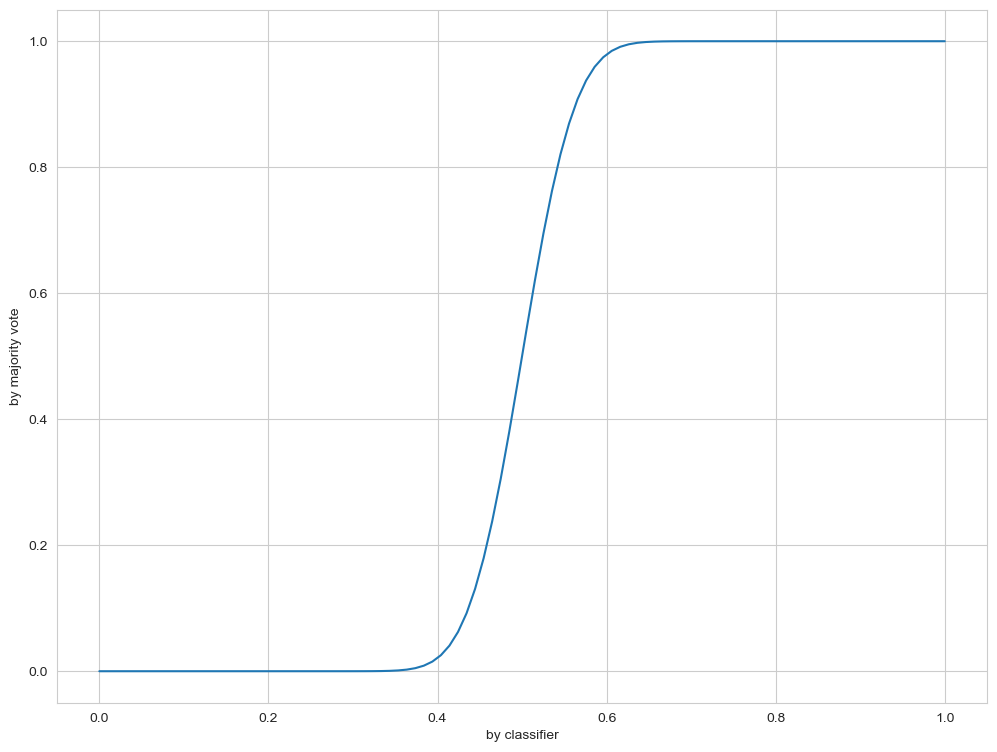

In [6]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##


n = 101
p_values = np.linspace(0, 1, 100)
probs = []

for p in p_values:
    prob_correct = sum([comb(n, i) * p**i * (1-p)**(n-i) for i in range((n//2) + 1, n+1)])
    probs.append(prob_correct)
    
plt.plot(p_values, probs)
plt.xlabel('by classifier')
plt.ylabel('by majority vote')
plt.show()

А теперь давайте посмотрим на другую ситуацию. У нас есть фиксированная вероятность того, что модель правильно классифицирует объект `p = 0.65`. Постройте зависимость вероятности правильно классифицировать объект от числа моделей в ансамбле.

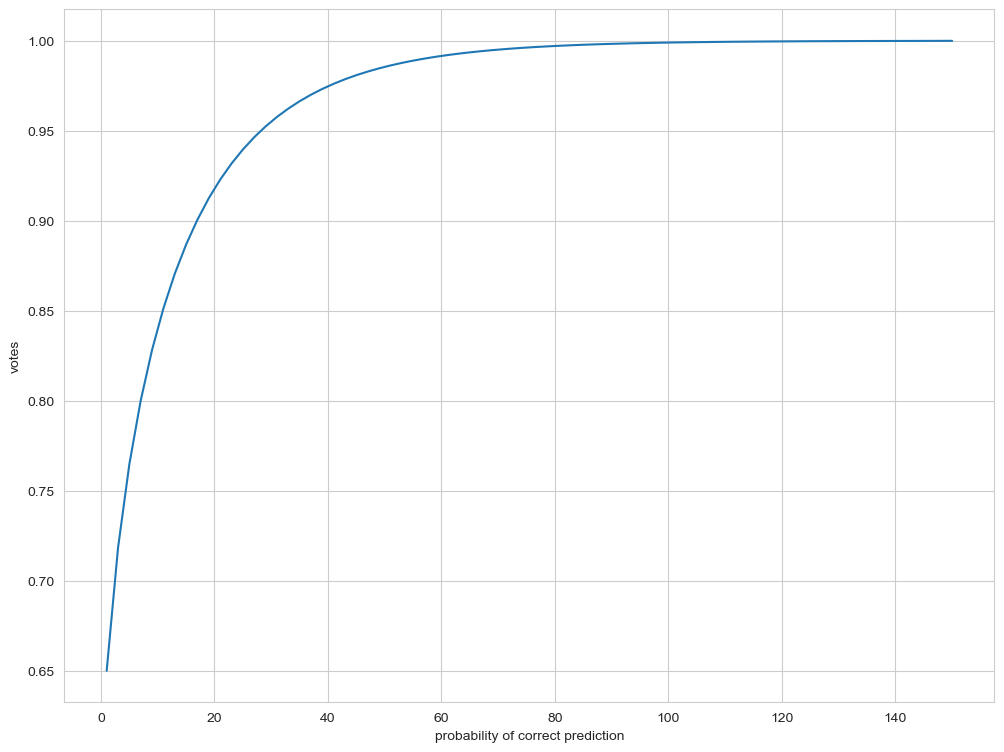

In [7]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

ns = list(map(int, np.linspace(1,150,75)))
p = 0.65
probs = []

for n in ns:
    prob_correct = sum([comb(n, i) * p**i * (1-p)**(n-i) for i in range((n//2) + n%2, n+1)])
    probs.append(prob_correct)
    
plt.plot(ns, probs)
plt.xlabel('probability of correct prediction')
plt.ylabel('votes')
plt.show()

Опишите ваши наблюдения:

* чем выше верояность предскзания одной модели, тем выше majority
* судя по всему для хорошего предсказания, нужно минимум 100 голосов при p=0.65

#### Задание 2. 2. Реализация простого RF

**4 балла**

Реализуйте свой собственный класс `RandomForestClassifierCustom`, используя в качестве базовой модели `DecisionTreeClassifier` из `sklearn`.

Небольшое описание:
- Используйте приведенный ниже код
- В методе `fit` в цикле (`i` от 0 до `n_estimators-1`):
    * Зафиксируйте генератор случайных чисел следующим образом np.random.seed(`random_state + i`). Идея в том, что на каждой итерации у нас будет новое значение для генератора случайных чисел, что добавит побольше "случайности", но в то же время мы сможем иметь воспроизводимые результаты
    * После чего выберите `max_features` признаков **без возвращения/without replacement**, сохраните список выбранных признаков (их индексов) в `self.feat_ids_by_tree`
    * Также создайте псевдовыборку при помощи бутстрэпа (выбор **с возвращением/with replacement**) из тренировочных данных. Может помочь функция `np.random.choice` и ее аргумент `replace`
    * Обучите дерево решений с параметрами, заданными в конструкторе класса `max_depth`, `max_features` и `random_state` на полученной псевдовыборке.
- Метод `fit` должен возвращать текущий экземпляр класса `RandomForestClassifierCustom`, то есть `self` (все по-взрослому, как в `sklearn`)
- В методе `predict_proba` мы должны пройти циклом по всем деревьям. Для каждого предсказания, нам нужно будет брать только те признаки, на которых училось изначальное дерево, поэтому мы и сохраняли эту информацию в артрибуте `self.feat_ids_by_tree`. Этот метод должен возвращать предсказанные вероятности (можно делать двумя способами: для каждого дерева предсказывать значение при помощи метода `predict_proba` и потом усреднять эти вероятности, или к примеру пользоваться методом `predict` и также считать среднее.

In [8]:
class RandomForestClassifierCustom(BaseEstimator):
    def __init__(
        self, n_estimators=10, max_depth=None, max_features=None, random_state=SEED
    ):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.random_state = random_state

        self.trees = []
        self.feat_ids_by_tree = []

    def fit(self, X, y):
        
        self.classes_ = sorted(np.unique(y))
        
        for i in range(self.n_estimators):
            
            np.random.seed(self.random_state + i)
            
            features_ids = np.random.choice(X.shape[1], self.max_features, replace=False)
            self.feat_ids_by_tree.append(features_ids)
            
            bootstrap_ids = np.random.choice(X.shape[0], X.shape[0], replace=True)
            X_bootstrap = X[bootstrap_ids, :][:, features_ids]
            y_bootstrap = y[bootstrap_ids]
            
            tree = DecisionTreeClassifier(
                max_depth=self.max_depth,
                max_features=self.max_features,
                random_state=self.random_state,
            )
            tree.fit(X_bootstrap, y_bootstrap)
            self.trees.append(tree)

        return self            
            
    def predict_proba(self, X):
        probas = np.zeros((X.shape[0], len(self.classes_)))
        
        for i, tree in enumerate(self.trees):
            features_ids = self.feat_ids_by_tree[i]
            X_tree = X[:, features_ids]
            tree_probas = tree.predict_proba(X_tree)
            probas += tree_probas
        
        return probas / len(self.trees)
    
    def predict(self, X):
        probas = self.predict_proba(X)
        predictions = np.argmax(probas, axis=1)
        
        return predictions

Протестируем нашу реализацию на искусственных данных. Визуализируйте разделяющую границу, которую рисует ваша модель при помощи функции `plot_decision_boundary` (см. примеры в лекции).

In [9]:
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(["#ffdab9","#9898ff", "#4B0082"])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(["#ffdab9", "#4c4c7f", "#4B0082"])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

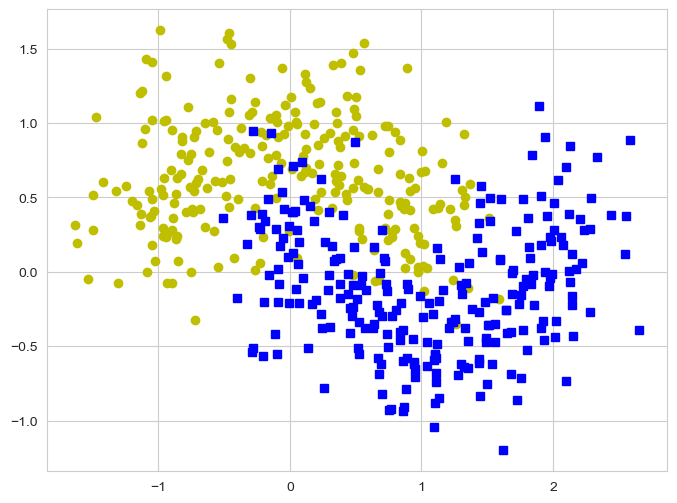

In [10]:
X, y = datasets.make_moons(n_samples=500, noise=0.30, random_state=SEED)

plt.figure(figsize=(8, 6))
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.show()

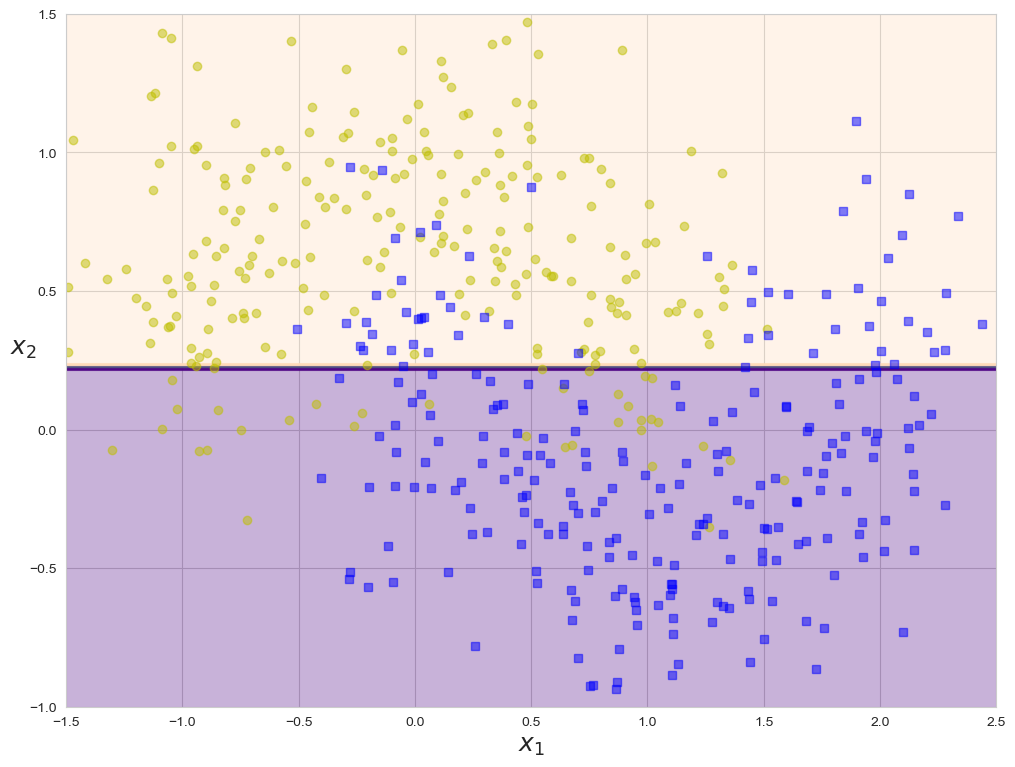

In [11]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

clf = RandomForestClassifierCustom(n_estimators=100, max_depth=1, max_features=2, random_state=SEED)
clf.fit(X, y)
plot_decision_boundary(clf, X, y)

Подберите наилучшие гиперпараметры, при которых разделяющая граница будет, на ваш взгляд, оптимальной с точки зрения bias-variance. Можно также подключить какие-то метрики для выбора лучшей модели.

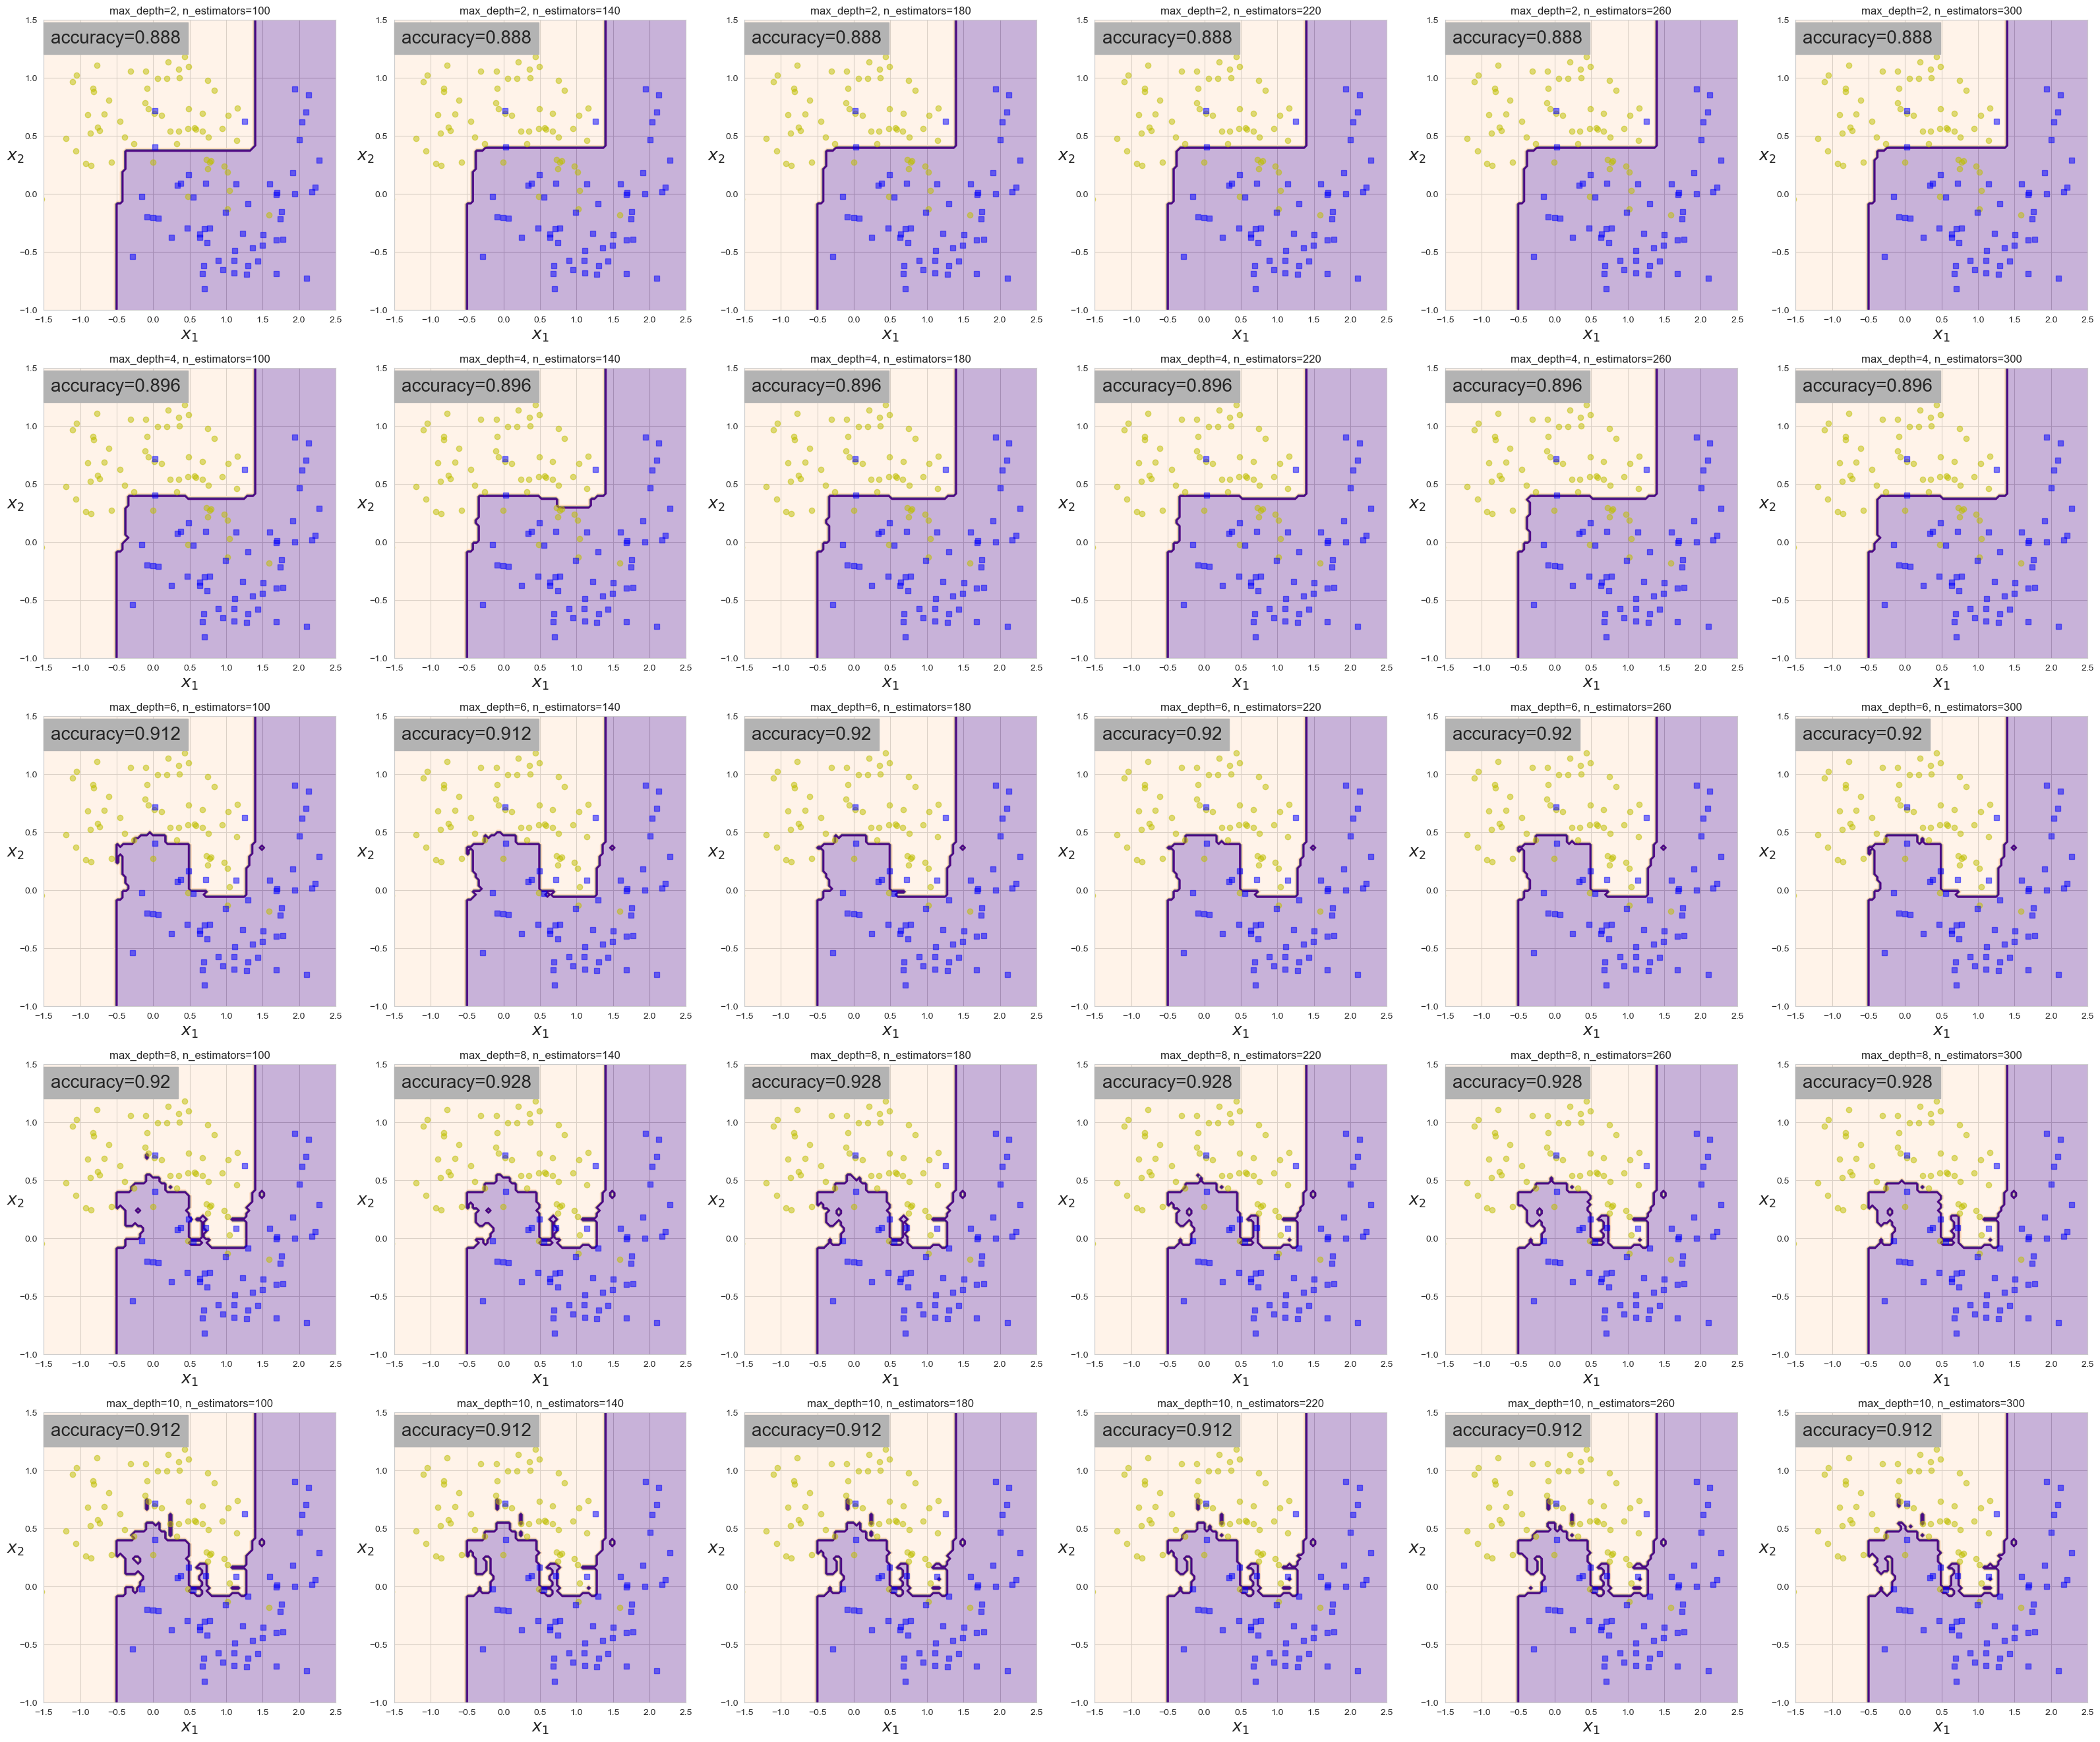

<Figure size 1000x1000 with 0 Axes>

In [12]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)

plt.figure(figsize=(40, 40))
plot_ind = 1
for depth in range(2,11,2):
    for n in range(100,301,40):
        clf = RandomForestClassifierCustom(max_depth=depth, max_features=2, n_estimators=n)
        clf.fit(X_train,y_train)
        y_pred = clf.predict(X_test)
        plt.subplot(6,6,plot_ind)
        plot_decision_boundary(clf, X_test, y_test)
        plt.title(f'max_depth={depth}, n_estimators={n}')
        plt.text(-1.4, 1.3, f'accuracy={accuracy_score(y_test, y_pred)}', 
                 backgroundcolor='0.7', size=20)
        plot_ind += 1

plt.figure(figsize=(10,10))
plt.show()

по результатам, лучший вариант max_depth=8, a n_estimators от 140

#### Задание 2. 3. Корреляция базовых моделей

**3 балла**

Как мы выянили на лекции, для того, чтобы bagging работал хорошо, предсказания наших моделей не должны сильно коррелировать. Для этого в случайном лесе применяются различные подходы, в том числе и RSM. Давайте посмотрим, как влияет параметр `max_features` на корреляцию базовых моделей в случайном лесу из `sklearn`. В качестве примера будем использовать датасет `breast_cancer`. Для расчета корреляций используйте приведенную ниже функцию `base_model_pair_correlation`. Для каждой модели у вас будет получаться набор значений (попарные корреляции всех деревьев), дальше можно изобразить их в виде боксплотов, как мы на лекции рисовали распределение метрик.

In [13]:
# Функция для расчета попарных корреляций базовых моделей в случайном лесу
def base_model_pair_correlation(ensemble, X):
    corrs = []
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        ypred_t2 = est2.predict_proba(Xj_test)[:, 1]

        corrs.append(pearsonr(ypred_t1, ypred_t2)[0])
    return np.array(corrs)

In [14]:
# Загрузим данные
breast_cancer = datasets.load_breast_cancer()
X = breast_cancer.data
y = breast_cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)

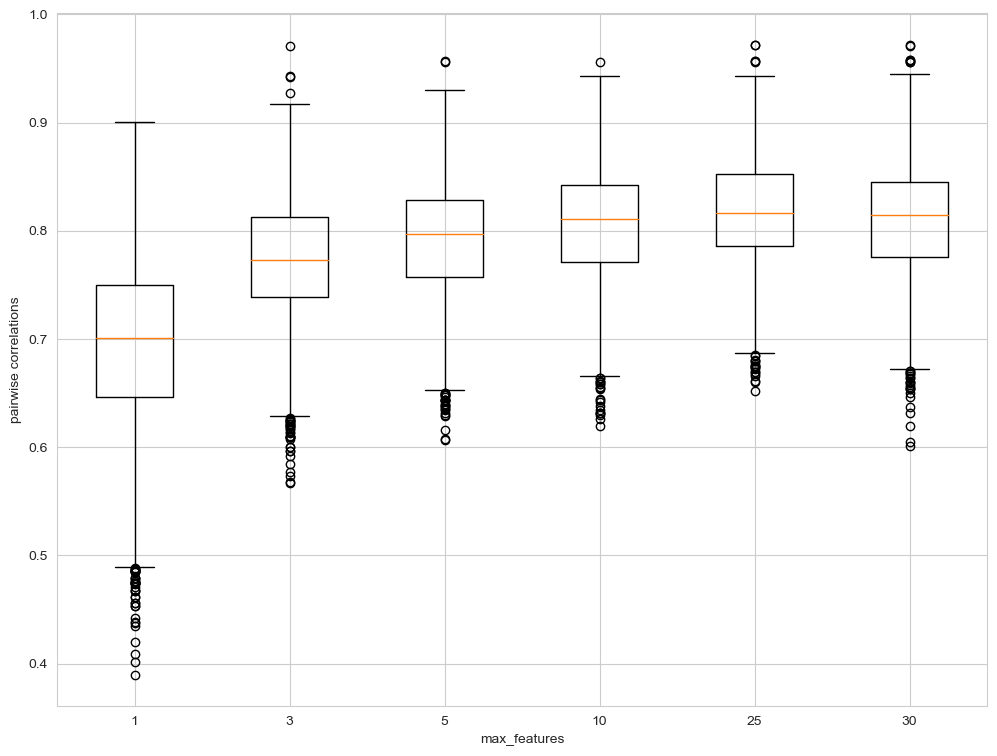

In [15]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
max_features_values = [1, 3, 5, 10, 25, 30]

corrs = []
    
for max_feat in max_features_values:
    rf = RandomForestClassifier(max_features=max_feat)
    rf.fit(X_train, y_train)
    corrs.append(base_model_pair_correlation(rf, X_test))

plt.boxplot(corrs, labels=max_features_values)
plt.xlabel('max_features')
plt.ylabel('pairwise correlations')
plt.show()

Теперь давайте посмотрим, как на это влияет параметр `max_depth`:

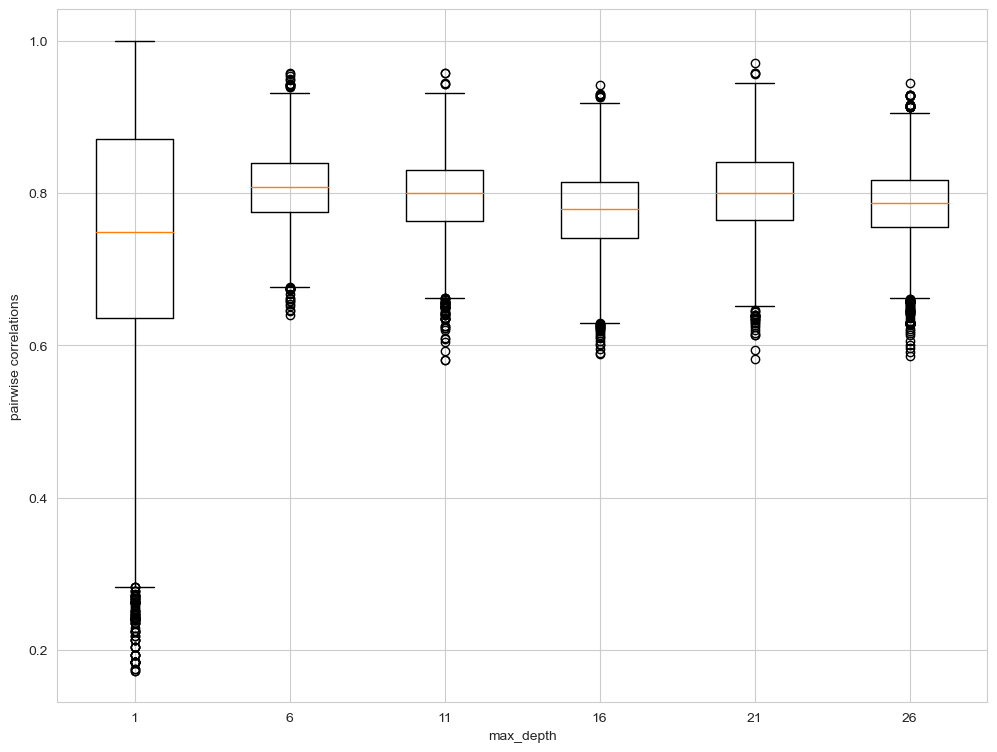

In [16]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

corrs = []
    
for max_depth in range(1, 30, 5):
    rf = RandomForestClassifier(max_depth=max_depth)
    rf.fit(X_train, y_train)
    corrs.append(base_model_pair_correlation(rf, X_test))

plt.boxplot(corrs, labels=range(1, 30, 5))
plt.xlabel('max_depth')
plt.ylabel('pairwise correlations')
plt.show()

Опишите ваши наблюдения:

* при увеличении max_features вероятность увеличивается с постепенным выходом на плато
* при увеличении max_depth вероятность повышается до определенных значений, после чего снова снижается (при 1 совсем не очень все выглядит)

### Задание 3. Строим большой ансамбль

**4 балла + 3 дополнительных за скор выше 0.89**

В данной задаче вам нужно диагностировать сердечное заболевание у людей по медицинским показателям.

In [17]:
#!gdown  --id 1VFbDK-Ad-hpf0_GGCBzn4thdn9mkQ-Y- -O heart.csv -q
heart_dataset = pd.read_csv("heart.csv")

In [18]:
X = heart_dataset.drop("target", axis=1)
y = heart_dataset["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)
X_train.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
178,43,1,0,120,177,0,0,120,1,2.5,1,0,3
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3
201,60,1,0,125,258,0,0,141,1,2.8,1,1,3
246,56,0,0,134,409,0,0,150,1,1.9,1,2,3
153,66,0,2,146,278,0,0,152,0,0.0,1,1,2


Обучите разнообразные классификаторы, приведенные ниже, а также ансамбль `VotingClassifier` из `sklearn.ensemble`, объединяющий эти классификаторы с помощью жесткого или мякого голосования (параметр `voting =` `'hard'` или `'soft'` соответственно). Оцените качество моделей с помощью кросс-валидации на тренировочном наборе, используя функцию `cross_val_score` и метрику `f1`. Часть моделей отсюда мы не проходили, о них можно почитать дополнительно, но в принципе для задания не очень важно знать принципы их работы (но, если есть время, то почитайте, там интересно).

In [19]:
dt = DecisionTreeClassifier(random_state=SEED, max_depth=10, min_samples_leaf=10)
rf = RandomForestClassifier(n_estimators=50, random_state=SEED)
etc = ExtraTreesClassifier(random_state=SEED)
knn = KNeighborsClassifier(n_neighbors=5, weights="distance")
svc_lin = SVC(kernel='linear', probability=True, random_state=SEED)
svc_rbf = SVC(kernel='rbf', probability=True, random_state=SEED)
cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
lgbm = lightgbm.LGBMClassifier(random_state=SEED)
lgbm_rf = lightgbm.LGBMClassifier(boosting_type="rf", bagging_freq=1, bagging_fraction=0.7, random_state=SEED)
xgb = xgboost.XGBClassifier(random_state=SEED)
xgb_rf = xgboost.XGBRFClassifier(random_state=SEED)
lr = LogisticRegression(solver='liblinear', max_iter=10000)
nb = GaussianNB()

base_models = [("DT", dt), ("RF", rf), 
               ("ETC", etc), ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("CAT", cat), ("LGBM", lgbm), 
               ("LGBM_RF", lgbm_rf), ("XGB", xgb), 
               ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]

Здесь могут возникать различные предупреждения при обучении бустингов, не волнуйтесь, все нормально, просто они обычно очень разговорчивые)

In [20]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
voting_hard = VotingClassifier(estimators=base_models, voting='hard')
voting_soft = VotingClassifier(estimators=base_models, voting='soft')


## END YOUR CODE HERE ##

for model in [dt, rf, cat, etc, knn, svc_lin, svc_rbf, xgb, 
              lgbm, xgb_rf, lgbm_rf, lr, nb, voting_hard, voting_soft]: 
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1")
    print(f"{model.__class__.__name__}: {scores.mean()}")

DecisionTreeClassifier: 0.797997226792219
RandomForestClassifier: 0.8328751280279528
CatBoostClassifier: 0.8342715174922052
ExtraTreesClassifier: 0.828174603174603
KNeighborsClassifier: 0.6493313763861709
SVC: 0.8403098469098905
SVC: 0.6973119072190279
XGBClassifier: 0.820158269808819
LGBMClassifier: 0.8170106316447779
XGBRFClassifier: 0.8396975787156666
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Curr

Вы можете заметить, что ансамбль показывает хорошее, но не лучшее качество предсказания, попробуем его улучшить. Как вы знаете, ансамбли работают лучше, когда модели, входящие в них не скоррелированы друг с другом. Определите корреляцию предсказаний базовых моделей в ансамбле на тестовом наборе данных, и удалите из ансамбля те модели, чьи предсказания будут сильнее коррелировать с остальными. Воспользуйтесь функцией `base_model_pair_correlation_for_voting_clf`. **Спойлер**: далеко не факт, что если вы удалите две модели с корреляцией 0.95, то все станет сильно лучше, здесь все будет немного сложнее. Чтобы добиться максимального качества может понадобиться долгий перебор различных комбинаций моделей. Наилучший скор, который мне удалось достичь, это 0.915, но он получен весьма странной комбинацией алгоритмов, а еще и простым перебором всех вариантов)

In [21]:
def base_model_pair_correlation_for_voting_clf(ensemble, X):
    corrs = []
    base_model_names = [f"{est.__class__.__name__}" for est in ensemble.estimators_]
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        if not isinstance(est1, SVC):
            ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t1 = est1.decision_function(Xi_test)


        if not isinstance(est2, SVC):
            ypred_t2 = est2.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t2 = est2.decision_function(Xi_test)
        corrs.append((est1, est2, pearsonr(ypred_t1, ypred_t2)[0]))


    return corrs

In [22]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
ensemble = VotingClassifier(estimators=base_models, voting='soft')
ensemble.fit(X_train, y_train)
corrs = base_model_pair_correlation_for_voting_clf(ensemble, X_test)

In [23]:
for es1, es2, corr in corrs:
    print(f"{es1.__class__.__name__} vs {es2.__class__.__name__}: {corr}")

DecisionTreeClassifier vs RandomForestClassifier: 0.8134894007824364
DecisionTreeClassifier vs ExtraTreesClassifier: 0.7749544834941163
DecisionTreeClassifier vs KNeighborsClassifier: 0.31332949662835446
DecisionTreeClassifier vs SVC: 0.715376472596946
DecisionTreeClassifier vs SVC: 0.2820135356695378
DecisionTreeClassifier vs CatBoostClassifier: 0.7875690140798687
DecisionTreeClassifier vs LGBMClassifier: 0.8282760696670941
DecisionTreeClassifier vs LGBMClassifier: 0.8612656428887722
DecisionTreeClassifier vs XGBClassifier: 0.804966685796174
DecisionTreeClassifier vs XGBRFClassifier: 0.8822180964638209
DecisionTreeClassifier vs LogisticRegression: 0.7399817743086948
DecisionTreeClassifier vs GaussianNB: 0.6827714012201818
RandomForestClassifier vs ExtraTreesClassifier: 0.9215651183028867
RandomForestClassifier vs KNeighborsClassifier: 0.3924167426564557
RandomForestClassifier vs SVC: 0.8263983680718642
RandomForestClassifier vs SVC: 0.4055273375196602
RandomForestClassifier vs CatBoos

In [63]:
base_models = [("DT", dt), ("RF", rf), 
               ("ETC", etc), ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               #("CAT", cat), ("LGBM", lgbm), 
               #("LGBM_RF", lgbm_rf), 
               ("XGB", xgb), 
               ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]

In [64]:
voting_soft = VotingClassifier(estimators=base_models, voting='soft')
np.mean(cross_val_score(voting_soft, X_train, y_train, cv=3, scoring="f1"))

0.8441585514756248

In [62]:
base_models = [("DT", dt), 
               ("RF", rf), 
               #("ETC", etc), 
               ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("CAT", cat), 
               ("LGBM", lgbm), ("LGBM_RF", lgbm_rf), 
               ("XGB", xgb), 
               ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]
voting_soft = VotingClassifier(estimators=base_models, voting='soft')
np.mean(cross_val_score(voting_soft, X_train, y_train, cv=3, scoring="f1"))

0.8550318922749822

In [61]:
base_models = [("DT", dt), 
               ("RF", rf), 
               ("ETC", etc), 
               ("KNN", knn), 
               ("SVC_LIN", svc_lin), 
               ("SVC_RBF", svc_rbf), 
               ("CAT", cat), 
               ("LGBM", lgbm), 
               ("LGBM_RF", lgbm_rf), 
               ("XGB", xgb), 
               ("XGB_RF", xgb_rf), 
               ("LR", lr), 
               #("NB", nb)
              ]
voting_soft = VotingClassifier(estimators=base_models, voting='soft')
np.mean(cross_val_score(voting_soft, X_train, y_train, cv=3, scoring="f1"))

0.8580130043985466

In [60]:
base_models = [("DT", dt), 
               ("RF", rf), 
               #("ETC", etc), 
               ("KNN", knn), 
               ("SVC_LIN", svc_lin), 
               ("SVC_RBF", svc_rbf), 
               ("CAT", cat), 
               ("LGBM", lgbm), 
               ("LGBM_RF", lgbm_rf), 
               ("XGB", xgb), 
               ("XGB_RF", xgb_rf), 
               ("LR", lr), 
               #("NB", nb)
              ]
voting_soft = VotingClassifier(estimators=base_models, voting='soft')
np.mean(cross_val_score(voting_soft, X_train, y_train, cv=3, scoring="f1"))

0.8626984126984126

In [59]:
base_models = [("DT", dt), 
               ("RF", rf), 
               #("ETC", etc), 
               #("KNN", knn), 
               ("SVC_LIN", svc_lin), 
               ("SVC_RBF", svc_rbf), 
               ("CAT", cat), 
               ("LGBM", lgbm), 
               ("LGBM_RF", lgbm_rf), 
               ("XGB", xgb), 
               ("XGB_RF", xgb_rf), 
               ("LR", lr), 
               #("NB", nb)
              ]
voting_soft = VotingClassifier(estimators=base_models, voting='soft')
np.mean(cross_val_score(voting_soft, X_train, y_train, cv=3, scoring="f1"))

0.863016936732499

In [58]:
base_models = [("DT", dt), 
               ("RF", rf), 
               #("ETC", etc), 
               #("KNN", knn), 
               #("SVC_LIN", svc_lin), 
               ("SVC_RBF", svc_rbf), 
               ("CAT", cat), 
               ("LGBM", lgbm), 
               ("LGBM_RF", lgbm_rf), 
               ("XGB", xgb), 
               ("XGB_RF", xgb_rf), 
               ("LR", lr), 
               #("NB", nb)
              ]
voting_soft = VotingClassifier(estimators=base_models, voting='soft')
np.mean(cross_val_score(voting_soft, X_train, y_train, cv=3, scoring="f1"))

0.8662849105887082

In [57]:
base_models = [("DT", dt), 
               ("RF", rf), 
               #("ETC", etc), 
               #("KNN", knn), 
               ("SVC_LIN", svc_lin), 
               ("SVC_RBF", svc_rbf), 
               ("CAT", cat), 
               ("LGBM", lgbm), 
               ("LGBM_RF", lgbm_rf), 
               ("XGB", xgb), 
               #("XGB_RF", xgb_rf), 
               ("LR", lr), 
               #("NB", nb)
              ]
voting_soft = VotingClassifier(estimators=base_models, voting='soft')
np.mean(cross_val_score(voting_soft, X_train, y_train, cv=3, scoring="f1"))

0.8662849105887082

In [56]:
base_models = [("DT", dt), 
               #("RF", rf), 
               ("ETC", etc), 
               #("KNN", knn), 
               #("SVC_LIN", svc_lin), 
               #("SVC_RBF", svc_rbf), 
               ("CAT", cat), 
               ("LGBM", lgbm), 
               #("LGBM_RF", lgbm_rf), 
               #("XGB", xgb), 
               #("XGB_RF", xgb_rf), 
               ("LR", lr), 
               #("NB", nb)
              ]
voting_soft = VotingClassifier(estimators=base_models, voting='soft')
np.mean(cross_val_score(voting_soft, X_train, y_train, cv=3, scoring="f1"))

0.8704208031644359

In [55]:
base_models = [#("DT", dt), 
               #("RF", rf), 
               #("ETC", etc), 
               #("KNN", knn), 
               #("SVC_LIN", svc_lin), 
               #("SVC_RBF", svc_rbf), 
               #("CAT", cat), 
               #("LGBM", lgbm), 
               #("LGBM_RF", lgbm_rf), 
               #("XGB", xgb), 
               #("XGB_RF", xgb_rf), 
               ("LR", lr), 
               #("NB", nb)
              ]
voting_soft = VotingClassifier(estimators=base_models, voting='soft')
np.mean(cross_val_score(voting_soft, X_train, y_train, cv=3, scoring="f1"))

0.8500073681108163

In [54]:
base_models = [#("DT", dt), 
               #("RF", rf), 
               #("ETC", etc), 
               #("KNN", knn), 
               #("SVC_LIN", svc_lin), 
               #("SVC_RBF", svc_rbf), 
               #("CAT", cat), 
               #("LGBM", lgbm), 
               #("LGBM_RF", lgbm_rf), 
               #("XGB", xgb), 
               ("XGB_RF", xgb_rf), 
               ("LR", lr), 
               #("NB", nb)
              ]
voting_soft = VotingClassifier(estimators=base_models, voting='soft')
np.mean(cross_val_score(voting_soft, X_train, y_train, cv=3, scoring="f1"))

0.8597181665184439

In [53]:
base_models = [#("DT", dt), 
               #("RF", rf), 
               #("ETC", etc), 
               #("KNN", knn), 
               #("SVC_LIN", svc_lin), 
               #("SVC_RBF", svc_rbf), 
               ("CAT", cat), 
               #("LGBM", lgbm), 
               #("LGBM_RF", lgbm_rf), 
               #("XGB", xgb), 
               #("XGB_RF", xgb_rf), 
               ("LR", lr), 
               #("NB", nb)
              ]
voting_soft = VotingClassifier(estimators=base_models, voting='soft')
np.mean(cross_val_score(voting_soft, X_train, y_train, cv=3, scoring="f1"))

0.8694543828264759

Я перебрала все варианты (кажется), но не нашла ничего лучше 0.87 


**Лучшие варианты:** 
- cat+lr = 0.869
- dt + etc + cat + lgbm + lr = 0.870

In [ ]:
import itertools

def evaluate_ensemble(ensemble, X_train, y_train):

    return np.mean(cross_val_score(ensemble, X_test, y_test, cv=3, scoring="f1"))

base_models = [("DT", dt), ("RF", rf), 
               ("ETC", etc), ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("CAT", cat), ("LGBM", lgbm), 
               ("LGBM_RF", lgbm_rf), ("XGB", xgb), 
               ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]

best_ensemble = None
best_score = 0.0

for L in range(1, len(base_models)+1):
    for subset in itertools.combinations(base_models, L):
        ensemble = VotingClassifier(list(subset), voting="soft")
        score = evaluate_ensemble(ensemble, X_test, y_test)
        if score > best_score:
            best_ensemble = ensemble
            best_score = score
            print(f"New best score: {best_score:.4f} for ensemble: {list(subset)}")

print(f"Best ensemble: {best_ensemble.estimators}")
print(f"Best accuracy: {best_score:.4f}")


очистила огромный оутпут

### Задание 4. Определение оттока клиентов из телекома

**6 баллов + 7 дополнительных за высокое качество модели и различные эксперименты**

Будем предсказывать, уйдет ли от нас клиент (переменная `Churn?`). Данные можно скачать [здесь](https://www.kaggle.com/venky12347/churn-telecom). Это будет уже совсем взрослое задание, так как правильного ответа на него нет. Вам нужно будет разобраться с данными, правильно подготовить их для моделей, а также выбрать лучшую модель. 

Задача минимум:

Выберите 2 модели &mdash; один случайный лес и один бустинг из приведенных ниже:

1. `xgboost.XGBClassifier`
2. `xgboost.XGBRFClassifier` &mdash; случайный лес от xgboost
3. `lightgbm.LGBMClassifier`
4. `lightgbm.LGBMClassifier(boosting_type="rf")` &mdash; случайный лес от lightgbm
5. `catboost.CatBoostClassifier`

И попробуйте разобраться с тем, как для этих моделей правильно настраивать гиперпараметры. Советую гуглить примерно следующее `how to choose best hyperparameters for lightgbm`. Там вы найдете кучу сложного и непонятного кода, но если с ним разобраться и научиться обучать нестандартные бустинги, то в плане табличных данных равных вам не будет)

In [49]:
data = pd.read_csv("churn.csv")
data.head()

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,...,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


## EDA

In [50]:
data=data.rename(columns={'Churn?':'churn'})
data=data.rename(columns={"Int'l Plan":"Intl Plan"})

In [51]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   State           3333 non-null   object 
 1   Account Length  3333 non-null   int64  
 2   Area Code       3333 non-null   int64  
 3   Phone           3333 non-null   object 
 4   Intl Plan       3333 non-null   object 
 5   VMail Plan      3333 non-null   object 
 6   VMail Message   3333 non-null   int64  
 7   Day Mins        3333 non-null   float64
 8   Day Calls       3333 non-null   int64  
 9   Day Charge      3333 non-null   float64
 10  Eve Mins        3333 non-null   float64
 11  Eve Calls       3333 non-null   int64  
 12  Eve Charge      3333 non-null   float64
 13  Night Mins      3333 non-null   float64
 14  Night Calls     3333 non-null   int64  
 15  Night Charge    3333 non-null   float64
 16  Intl Mins       3333 non-null   float64
 17  Intl Calls      3333 non-null   i

In [19]:
data.describe()

,Account Length,Area Code,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,437.182418,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856
std,39.822106,42.371290,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491
min,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,408.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000
50%,101.000000,415.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000
75%,127.000000,510.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000
max,243.000000,510.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


In [20]:
data.duplicated().sum()
#все наблюдения уникальные

0

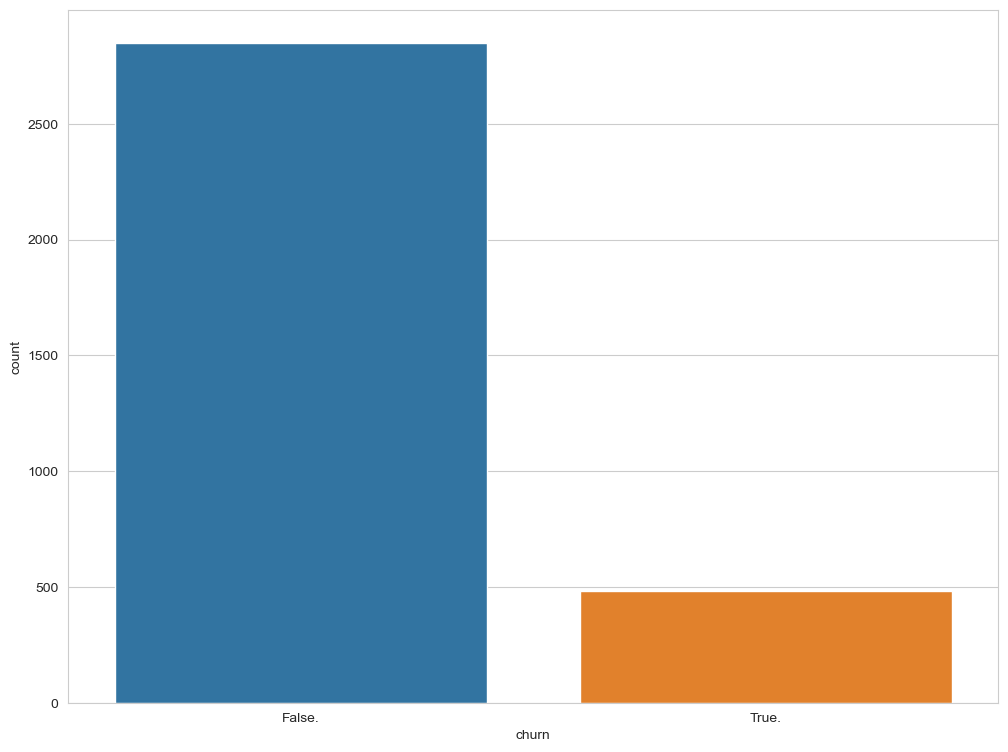

In [21]:
sns.countplot(x="churn", data=data);

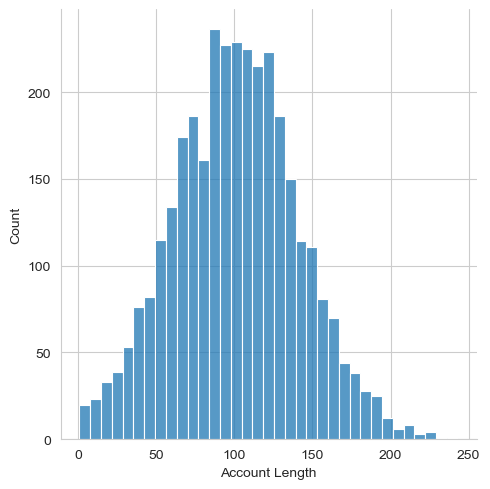

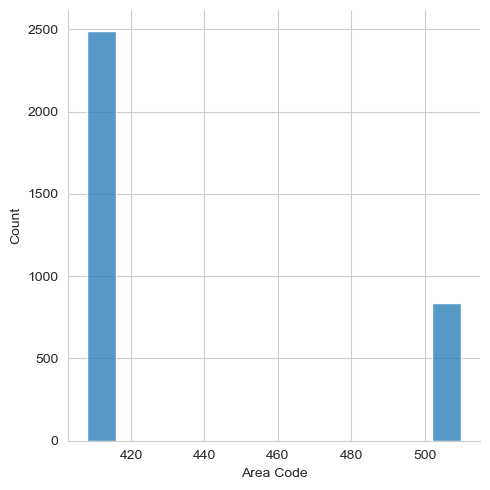

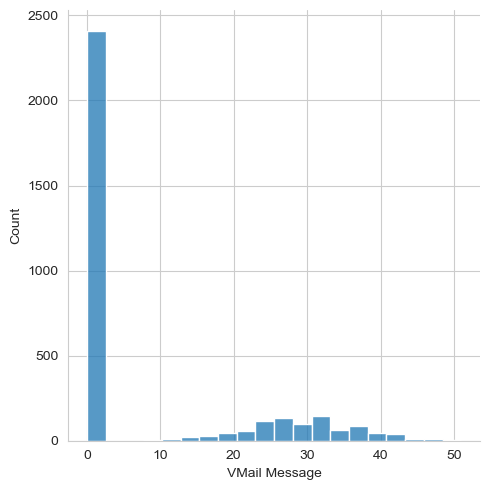

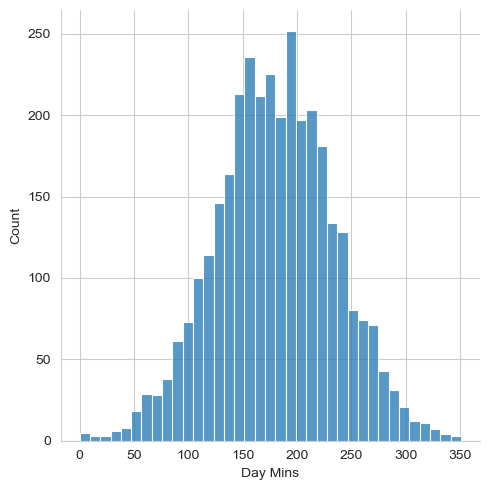

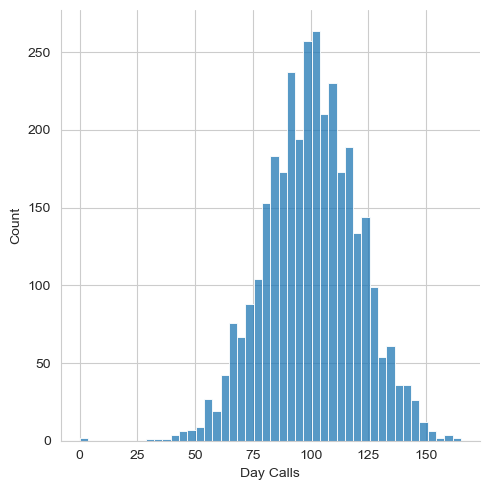

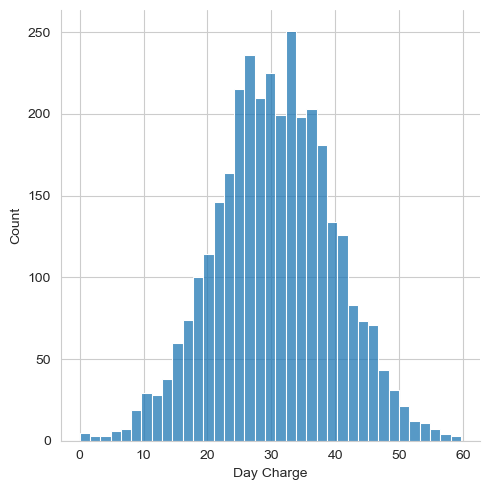

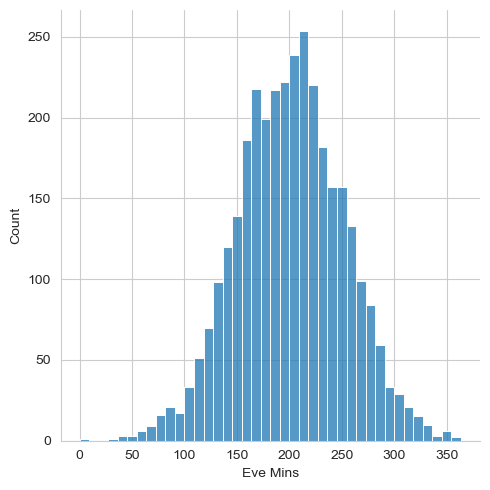

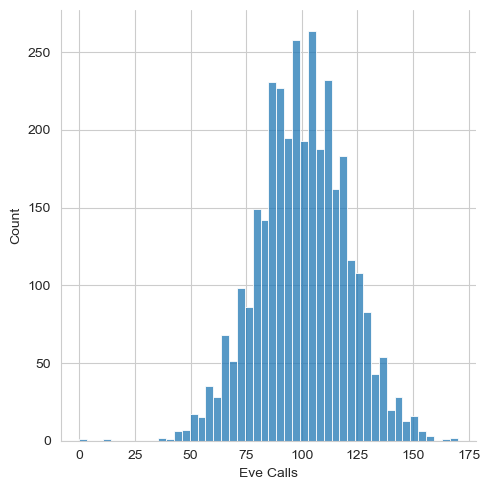

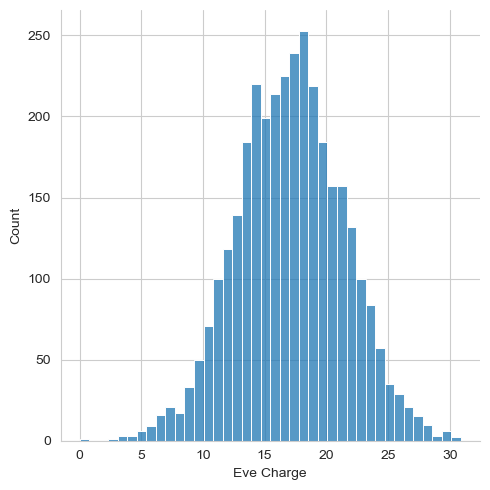

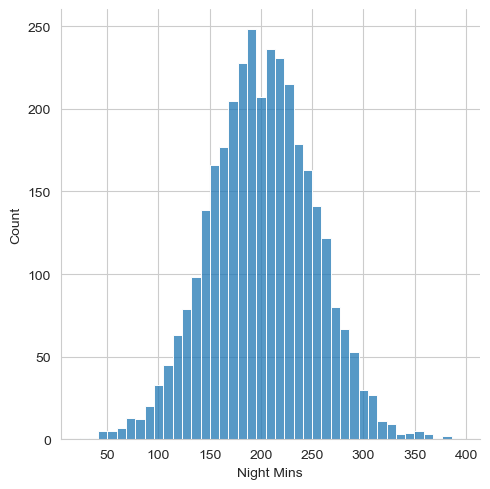

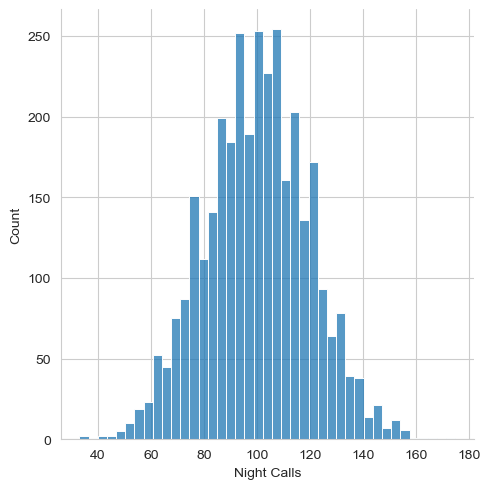

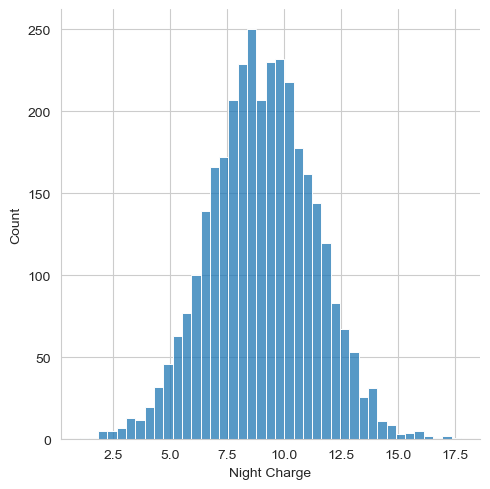

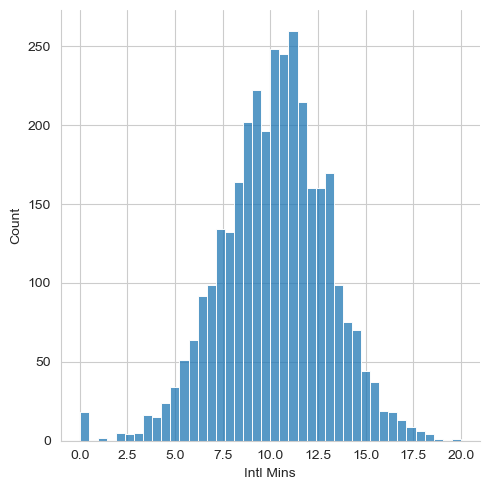

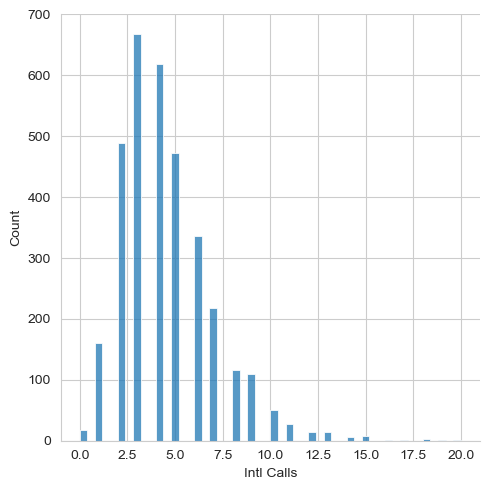

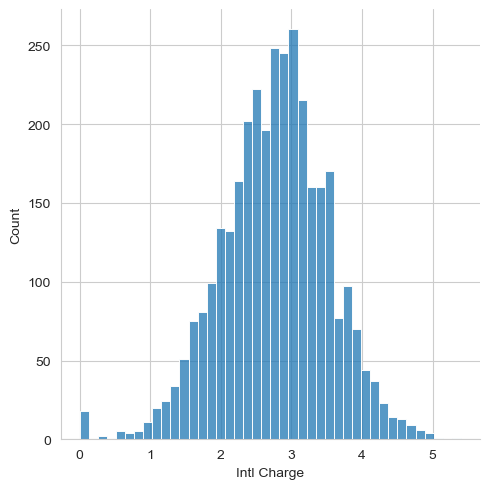

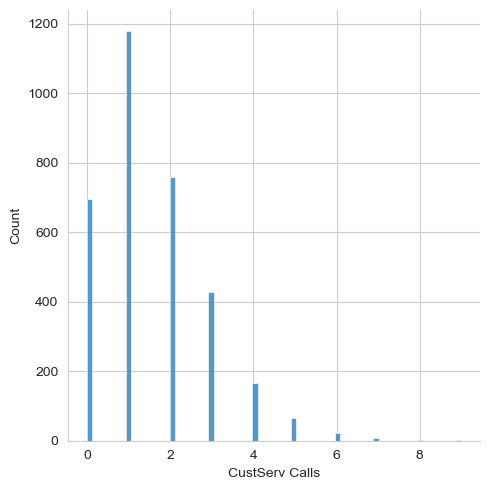

In [22]:
for col in data.columns:
    if data[col].dtype != "object":
        sns.displot(data[col]);

<Axes: >

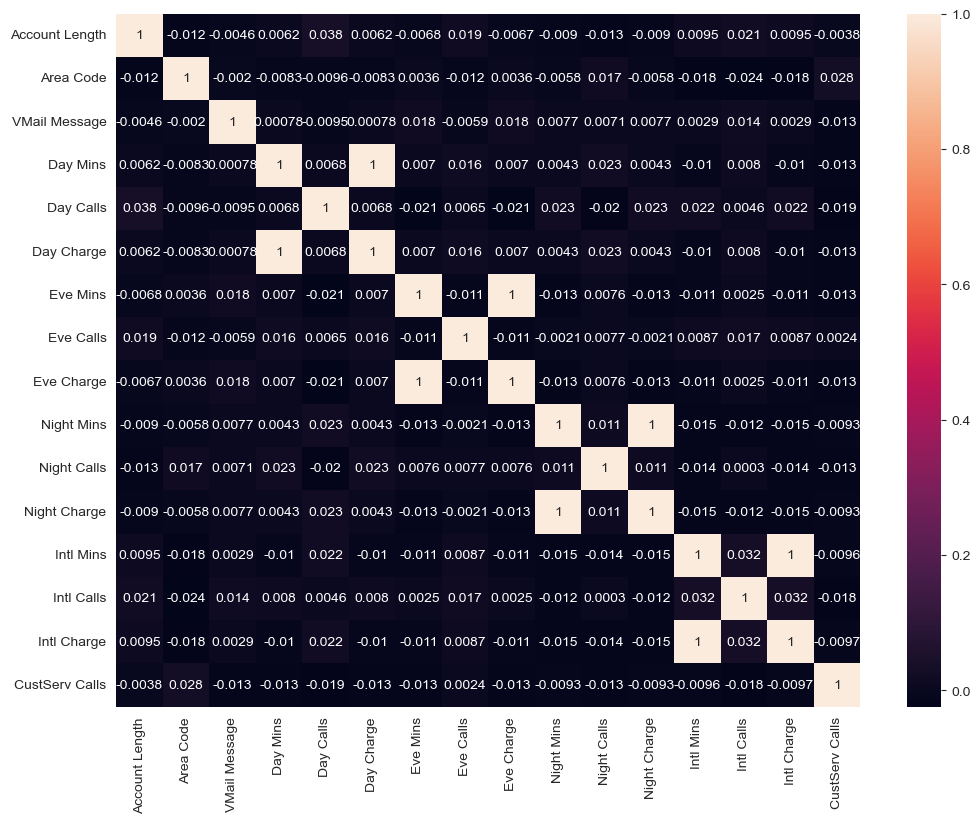

In [23]:
corr_matrix = data.corr()
sns.heatmap(corr_matrix, annot=True)

Mins and Charges корреллируют, оставим только одну. Так же выкинем мало информативные колонки

In [52]:
dr = ['Phone', 'Area Code', 'State', 'Day Mins', 'Eve Mins', 'Night Mins','Intl Mins']
data_clean = data.drop(dr, axis = 1)

In [53]:
data_clean.describe()

,Account Length,VMail Message,Day Calls,Day Charge,Eve Calls,Eve Charge,Night Calls,Night Charge,Intl Calls,Intl Charge,CustServ Calls
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,8.099010,100.435644,30.562307,100.114311,17.083540,100.107711,9.039325,4.479448,2.764581,1.562856
std,39.822106,13.688365,20.069084,9.259435,19.922625,4.310668,19.568609,2.275873,2.461214,0.753773,1.315491
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,33.000000,1.040000,0.000000,0.000000,0.000000
25%,74.000000,0.000000,87.000000,24.430000,87.000000,14.160000,87.000000,7.520000,3.000000,2.300000,1.000000
50%,101.000000,0.000000,101.000000,30.500000,100.000000,17.120000,100.000000,9.050000,4.000000,2.780000,1.000000
75%,127.000000,20.000000,114.000000,36.790000,114.000000,20.000000,113.000000,10.590000,6.000000,3.270000,2.000000
max,243.000000,51.000000,165.000000,59.640000,170.000000,30.910000,175.000000,17.770000,20.000000,5.400000,9.000000


In [28]:
data_clean.head()

,Account Length,Intl Plan,VMail Plan,VMail Message,Day Calls,Day Charge,Eve Calls,Eve Charge,Night Calls,Night Charge,Intl Calls,Intl Charge,CustServ Calls,churn
0,128,no,yes,25,110,45.07,99,16.78,91,11.01,3,2.70,1,False.
1,107,no,yes,26,123,27.47,103,16.62,103,11.45,3,3.70,1,False.
2,137,no,no,0,114,41.38,110,10.30,104,7.32,5,3.29,0,False.
3,84,yes,no,0,71,50.90,88,5.26,89,8.86,7,1.78,2,False.
4,75,yes,no,0,113,28.34,122,12.61,121,8.41,3,2.73,3,False.


In [54]:
data_clean.replace({"True.": 1, "False.": 0, 
              "yes": 1, "no": 0}, inplace=True)

In [55]:
y = data_clean.churn
data_clean = data_clean.drop('churn', axis=1)
X = data_clean

In [57]:
num_feats = ['Account Length', 'VMail Message', 'Day Calls', 'Day Charge', 
             'Eve Calls', 'Eve Charge', 'Night Calls', 'Night Charge', 
             'Intl Calls', 'Intl Charge', 'CustServ Calls']

preproccessor = ColumnTransformer(transformers=[
    ('scaler', StandardScaler(), num_feats)
])

## Выбираем модельку
(топ-модель по-MLски)    
тупая шутка, я знаю

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

In [61]:
cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
lgbm = lightgbm.LGBMClassifier(random_state=SEED)
lgbm_rf = lightgbm.LGBMClassifier(boosting_type="rf", bagging_freq=1, bagging_fraction=0.7, random_state=SEED)
xgb = xgboost.XGBClassifier(random_state=SEED)
xgb_rf = xgboost.XGBRFClassifier(random_state=SEED)

models = [cat,lgbm, 
          lgbm_rf, xgb, 
          xgb_rf]

In [62]:
for m in models:
    
    pipeline = make_pipeline(preproccessor, m)
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    print(m, accuracy_score(y_test, y_pred))

<catboost.core.CatBoostClassifier object at 0x1694bbd60> 0.9175412293853074
LGBMClassifier(random_state=111) 0.9295352323838081
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',
               random_state=111) 0.9010494752623688
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max

Все достаточно хороши, но лучший буст - LGBMClassifier    
Лучший случайный лес - XGBRFClassifier 

я не доделала, простите (очень грустно) 

миллион лет пыталась получить ско выше 0.91 в задании выше:((

### Задание 5. Рисуем

**дополнительно 0.5 балла**

Наверняка, в процессе выполнения этого задания вас переполняли какие-то эмоции. Нарисуйте что-то, что бы могло бы передать их (я сам не умею, так что, если это будет просто квадрат, тоже подойдет). Прикрепите сюда свой рисунок:

In [ ]:
## PASTE YOUR MASTERPIECE HERE (/¯◡ ‿ ◡)/¯☆*##

In [52]:
print('(╥﹏╥)')

(╥﹏╥)


### Therapy time

Напишите здесь ваши впечатления о задании (можно и не о задании): было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз.

**Ваши мысли:**